In [1]:
cd ../

/home/gridsan/cguo/rep_e_icl/rep_e_icl


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
from repe import repe_pipeline_registry
repe_pipeline_registry()
from tasks import get_task_dataset
from modules import *

In [4]:
import os
os.environ["TRANSFORMERS_OFFLINE"] ="1"
os.environ["TRANSFORMERS_CACHE"] = "/home/gridsan/groups/maia_mechint/models"

In [5]:
model_name_or_path = "meta-llama/Llama-2-7b-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto", token=True).eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

In [33]:
dataset_name = 'rotten_tomatoes'
positive_prompt = "Pay attention to the following examples."
negative_prompt = "Don't pay attention to the following exmaples."
ntrain = 64 
test_num_examples = 2
user_tag = "[INST]"
assistant_tag = "[/INST]"
dataset = get_task_dataset(dataset_name, positive_prompt, negative_prompt, ntrain=ntrain, test_num_examples=test_num_examples)

getting dataset for rotten_tomatoes
['negative', 'positive']
data len: 32
['negative', 'positive']
data len: 32
['negative', 'positive']
data len: 533


In [34]:
(dataset["test"]["data"][1], dataset["test"]["labels"][1])

("[INST] [/INST] rodriguez does a splendid job of racial profiling hollywood style--casting excellent latin actors of all ages--a trend long overdue .\npositive\nbeneath the film's obvious determination to shock at any cost lies considerable skill and determination , backed by sheer nerve .\n",
 'positive')

In [35]:
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)
rep_reader = get_rep_reader(model, rep_reading_pipeline, dataset)

["[INST] Don't pay attention to the following exmaples. [/INST] too silly to be frightening , too stolid to be funny , it projects the same lazy affability as its nominal star , david arquette .\nnegative\noften hilarious , well-shot and , importantly , entertaining , hell house is a fascinating document of an event that has to be seen to be believed .\npositive\n", "[INST] Pay attention to the following examples. [/INST] it's pretentious in a way that verges on the amateurish .\nnegative\nana is a vivid , vibrant individual and the movie's focus upon her makes it successful and accessible .\npositive\n", "[INST] Don't pay attention to the following exmaples. [/INST] manages to be wholesome and subversive at the same time .\npositive\nclint eastwood's blood work is a lot like a well-made pb& j sandwich : familiar , fairly uneventful and boasting no real surprises \x96 but still quite tasty and inviting all the same .\npositive\n", '[INST] Pay attention to the following examples. [/INST

In [36]:
dataset["test"]["data"]

['[INST] [/INST] compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .\npositive\nthe soundtrack alone is worth the price of admission .\n',
 "[INST] [/INST] rodriguez does a splendid job of racial profiling hollywood style--casting excellent latin actors of all ages--a trend long overdue .\npositive\nbeneath the film's obvious determination to shock at any cost lies considerable skill and determination , backed by sheer nerve .\n",
 "[INST] [/INST] bielinsky is a filmmaker of impressive talent .\npositive\nso beautifully acted and directed , it's clear that washington most certainly has a new career ahead of him if he so chooses .\n",
 '[INST] [/INST] a visual spectacle full of stunning images and effects .\npositive\na gentle and engrossing character study .\n',
 "[INST] [/INST] it's enough to watch huppert scheming , with her small , intelligent eyes as steady as any noir villain , and to

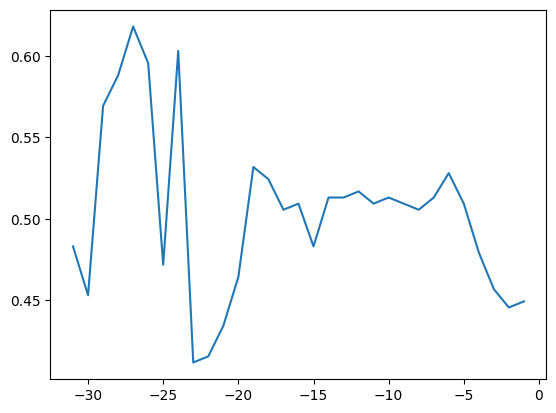

In [38]:
hidden_layers = get_hidden_layers(model)
H_tests = get_h_test(
    model, 
    rep_reading_pipeline, 
    rep_reader, 
    dataset
)
plot_correlation(rep_reader, H_tests, hidden_layers)

In [39]:
data = dataset["test"]["data"][1]
test_data = get_test_data(model, tokenizer, [data])
wanted_layers = range(-1, -32, -1)
rep_reader_scores_dict, rep_reader_scores_mean_dict = get_rep_reader_scores_dict(model, tokenizer, 
                                                                                 rep_reading_pipeline, 
                                                                                 rep_reader, 
                                                                                 test_data
                                                                                 )

In [41]:
THRESHOLD = 0.0 # change this to alter sensitivity
input_ids = tokenizer.tokenize(test_data[0])
plot_lat_scans(input_ids, rep_reader_scores_dict, layer_slice=slice(20, -20))

ValueError: '▁I' is not in list

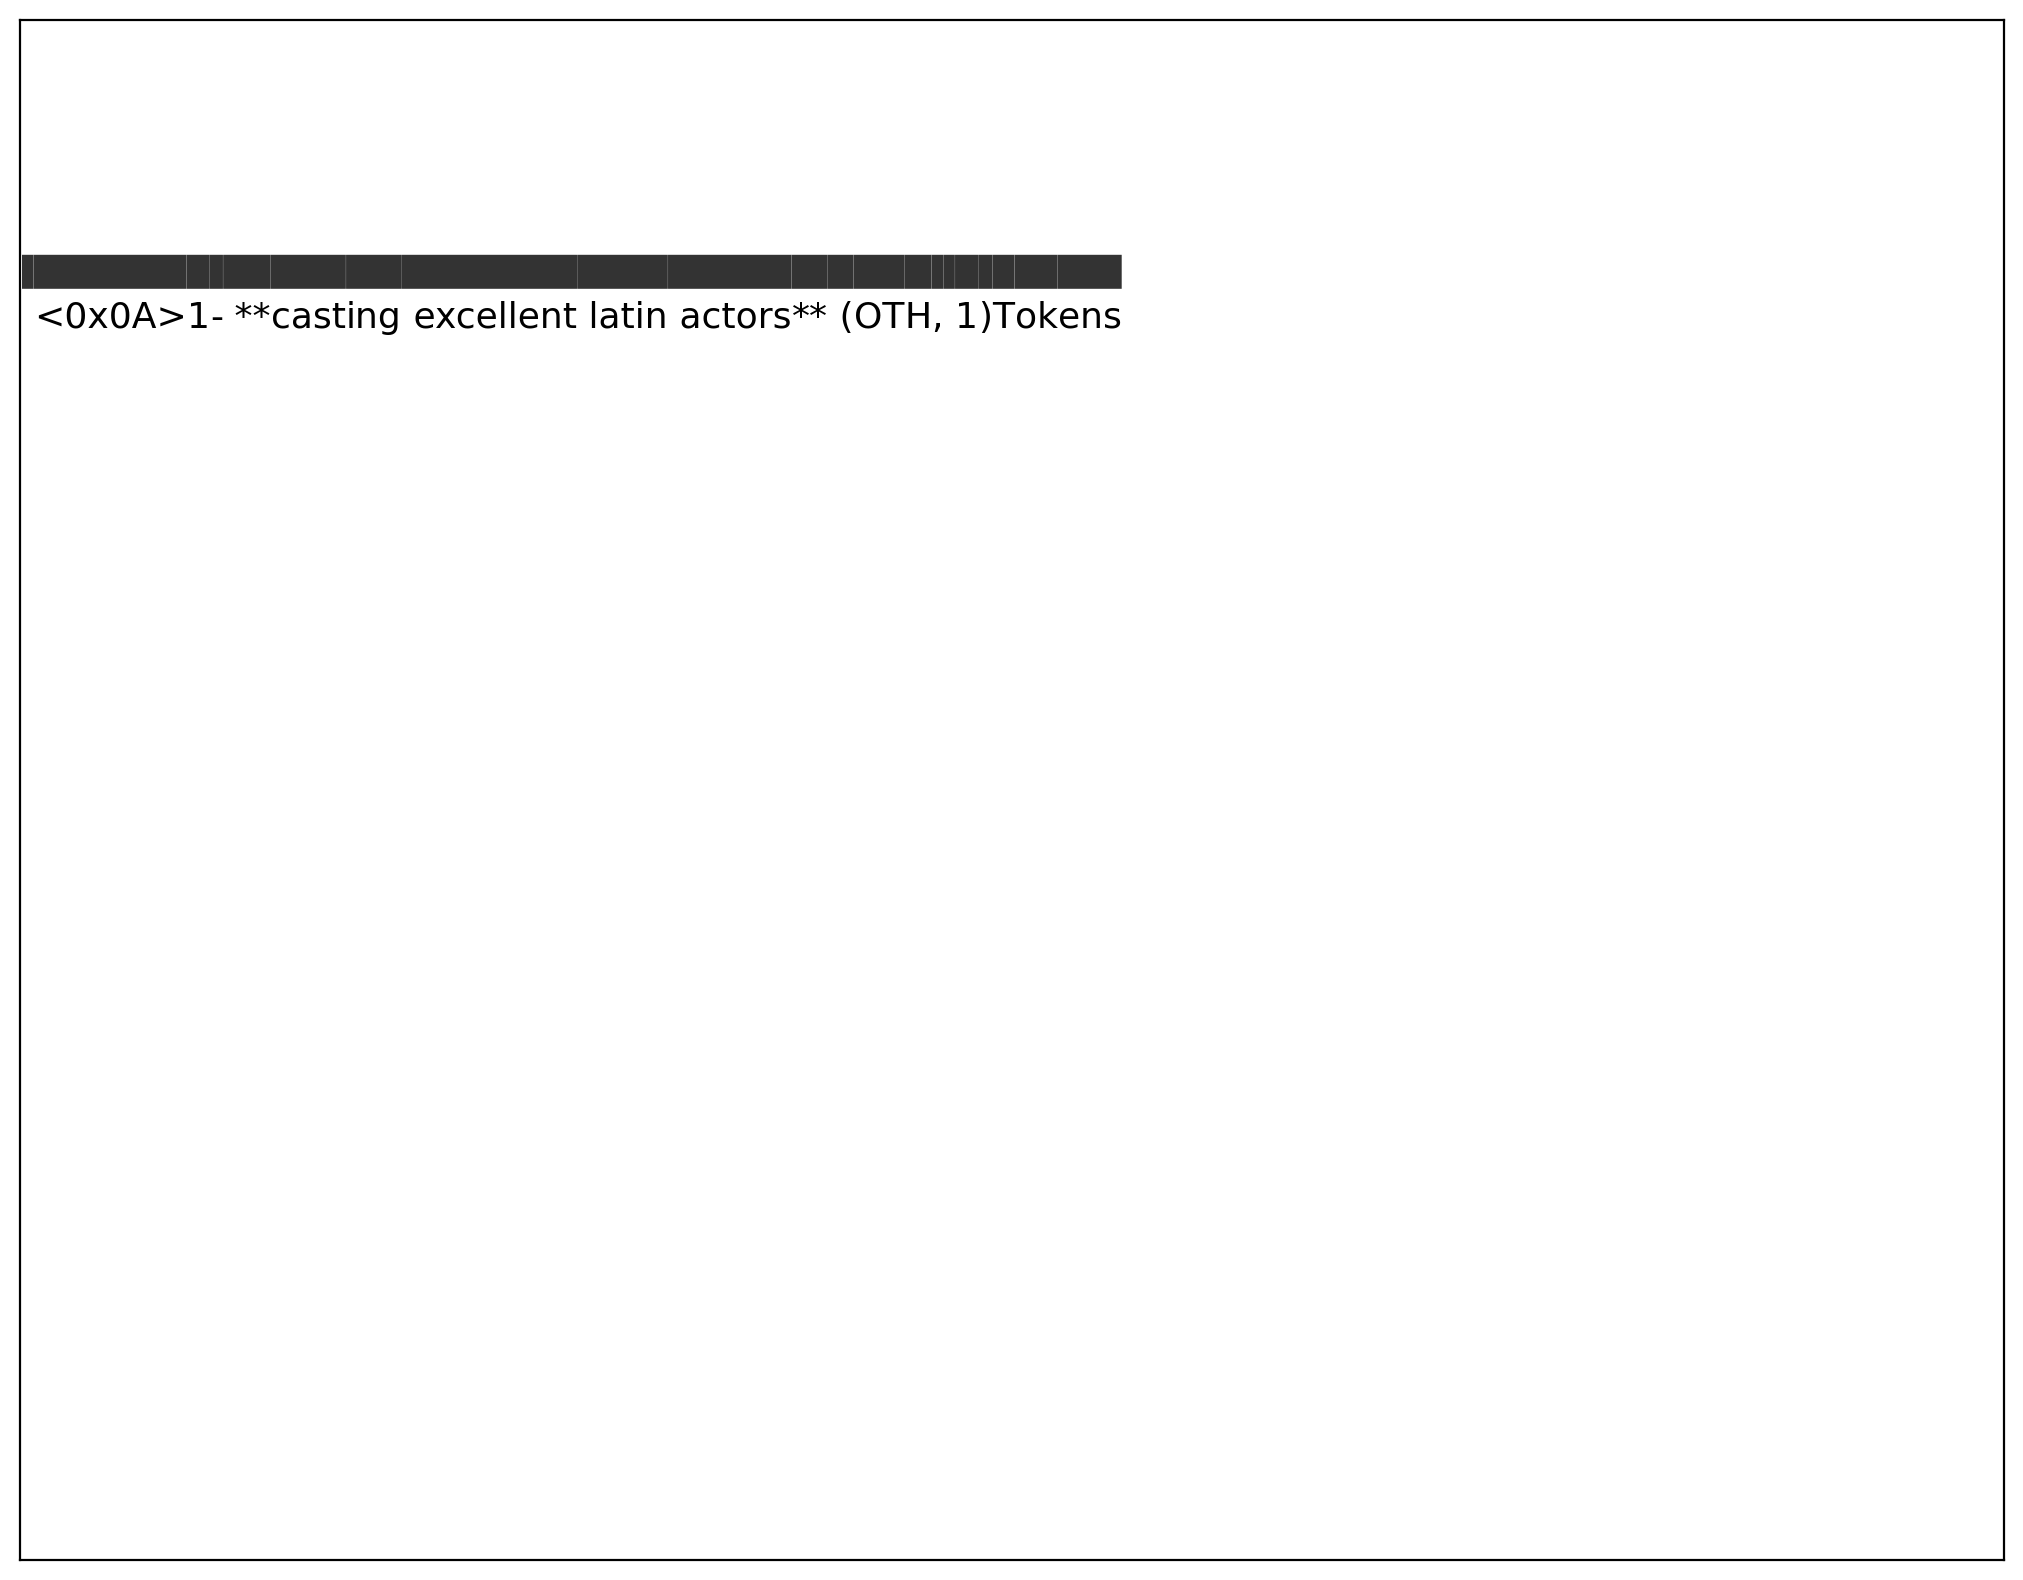

In [43]:
plot_detection_results(input_ids, rep_reader_scores_mean_dict, THRESHOLD, start_answer_token=tokenizer.tokenize(assistant_tag)[-1])

In [18]:
rep_control = get_rep_control(model, tokenizer)

In [30]:
max_layer = -5
min_layer = -18

layer_id = list(range(max_layer, min_layer, -1))
baseline, pos_results, neg_results = get_rep_controlled_results(rep_reader, rep_control, dataset["test"]["data"], layer_id)

Done with baseline results!
Done with control outputs!
Done with neg control outputs


In [33]:
dataset["test"]["labels"][0]

'positive'

In [39]:
acc_dict = get_acc_dict(baseline, pos_results, neg_results, dataset["test"]["labels"])

In [37]:
for a, b, c in zip(baseline, pos_results, neg_results): 
    print(a, b, c)
    print("-----")

positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive negative
the positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positive positive positive
-----
positi

In [40]:
acc_dict

{'baseline_acc': 0.9605633802816902,
 'pos_acc': 0.8366197183098592,
 'neg_acc': 0.7154929577464789}

'positive\n'